# Comparison of House Rules

In [1]:
from blackjacksim.simulations import Game
import matplotlib
%matplotlib inline
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(context='poster', fscale=1.4, spines=False, gridlines='--')

from blackjacksim.data import DefaultGameConfig
_def_conf = DefaultGameConfig()
def config(house_rules):
    _def_conf['house']['class'] = house_rules
    return _def_conf

try:
    df = df
except:
    df = None
pbar = tqdm(['Blackjack32', 'Blackjack65', 'Blackjack32NoSplit', 'Blackjack65NoSplit'])
trials = 200
rounds = 100
for house in pbar:
    for i in range(trials):
        pbar.set_description("{} {:04d}/{:04d}: ".format(house,i,trials-1))
        g = Game(config(house))
        for _ in range(rounds):
            g.round()
        if df is None:
            df = g.data 
        else:
            df = pd.concat([df,g.data]) 
            
sns.lineplot(x='Round', y='Pool', hue='House', data=df)
plt.show()

KeyboardInterrupt: 

# Example Dataloader

In [1]:
from blackjacksim.pytorch import BlackjackDataset
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
from blackjacksim.data import DefaultGameConfig
_def_conf = DefaultGameConfig()
def config(size, cut_card_position):
    _def_conf['shoe']['params']['size'] = size
    _def_conf['shoe']['params']['cut_card_position'] = cut_card_position
    return _def_conf


b = BlackjackDataset(batch_size=1000, config=config(1,.75), max_len=5000)


tbar = tqdm(b)
for S,w in tbar: 
    tbar.set_description("{}".format(w[w>0].sum()))


TypeError: unsupported operand type(s) for //: 'list' and 'int'

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         **kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(**kwargs)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.figure.colorbar(im, cax=cax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            

    
    fig.tight_layout()
    return ax

# Least Squares by Handtype

In [36]:
from blackjacksim.data import BasicStrategy
import numpy as np

basic = BasicStrategy()
action_to_class = {'Hit':[1,0,0,0],'Stand':[0,1,0,0],'Split':[0,0,1,0],'Double':[0.0,0,0,1]}
A = {'Hard':[], 'Soft':[], 'Splittable':[]}
b = {'Hard':[], 'Soft':[], 'Splittable':[]}
for dealer_up , v1 in basic.items():
    for hand_type, v2 in v1.items():
        for hand_value, action in v2.items():
            if hand_value == 'AA':
                hand_value = 22
            
            hand_value = int(hand_value)
            A[hand_type].append([int(dealer_up), int(hand_value)])
            #if action == 'Double':
                #action = 'Hit'
            b[hand_type].append(action_to_class[action])


# Naive classification without bias
for _type in ['Hard', 'Soft', 'Splittable']:
    _A = np.stack(A[_type])
    _b = np.stack(b[_type])
    Ai = np.linalg.pinv(_A)
    x = Ai@_b
    acc = (np.argmax(_A@x,1) == np.argmax(_b,1)).mean()
    print(acc)
    
def stable_softmax(X):
    exps = np.exp(X - np.max(X,1,keepdims=True))
    return exps / np.sum(exps,1, keepdims=True)

# Naive classification with bias
lab_to_class = list(action_to_class.keys())
acc_f = lambda f: (pred[f] == lab[f]).mean()
for _type in ['Hard', 'Soft', 'Splittable']:
    _A = np.stack(A[_type])
    _b = np.stack(b[_type])
    _A = np.concatenate([_A, np.ones((_A.shape[0],1))],1)
    Ai = np.linalg.pinv(_A)
    x = Ai@_b
    out = _A@x
    pred = np.argmax(out,1)
    lab = np.argmax(_b,1)
    acc = (pred == lab).mean()
    print(acc)
    wr = pred != lab
    print('Hit',out[lab==0].mean(0), acc_f(lab==0))
    print('Stand', out[lab==1].mean(0), acc_f(lab==1))
    print('Split', out[lab==2].mean(0), acc_f(lab==2))
    print('Double', out[lab==3].mean(0), acc_f(lab==3))
    #for o,s,p,l in zip(out[wr], _A[wr], pred[wr], lab[wr]):
        #print(o,s[:-1],lab_to_class[p],lab_to_class[l])

    

0.7555555555555555
0.52
0.6
0.8055555555555556
Hit [0.76147536 0.09787325 0.         0.14065138] 0.8604651162790697
Stand [0.11530274 0.80654249 0.         0.07815477] 0.9726027397260274
Split [nan nan nan nan] nan
Double [0.57600091 0.27168086 0.         0.15231823] 0.0
0.75
Hit [0.71016763 0.0722695  0.         0.21756286] 0.8936170212765957
Stand [0.10292929 0.77064279 0.         0.12642792] 1.0
Split [nan nan nan nan] nan
Double [0.51127273 0.20860606 0.         0.28012121] 0.0
0.66
Hit [0.50728485 0.0426303  0.31190303 0.13818182] 0.76
Stand [0.08198135 0.30515152 0.57230769 0.04055944] 0.07692307692307693
Split [0.14995338 0.14307692 0.61571096 0.09125874] 0.8846153846153846
Double [0.34545455 0.05272727 0.47454545 0.12727273] 0.0


/home/charlie/.virtualenvs/blackjacksim/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/home/charlie/.virtualenvs/blackjacksim/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/charlie/.virtualenvs/blackjacksim/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice.
/home/charlie/.virtualenvs/blackjacksim/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Least Squares by Card Value

In [12]:
from blackjacksim.entities import Deck, Hand
from blackjacksim.strategies import basic
import itertools
import numpy as np
import pandas as pd

action_to_class = {'Hit':[1,0,0,0],'Stand':[0,1,0,0],'Split':[0,0,1,0],'Double':[0.0,0,0,1]}

hands = [Hand(h) for h in itertools.product(Deck(),Deck())]
dups = Deck()

t = []
for hand, dup  in itertools.product(hands, dups):
    tup = tuple(c.value for c in (*hand,dup))
    c = (tup, basic(hand,dup))
    if c not in t:
        t.append(c)
print(len(t))
A = []
b = []
for  a, _b in t:
    A.append(a)
    b.append(action_to_class[_b])
    
A = np.stack(A)
b = np.array(b)

1001


Normalized confusion matrix
[[0.82826087 0.14782609 0.         0.02391304]
 [0.11551155 0.88448845 0.         0.        ]
 [0.45833333 0.54166667 0.         0.        ]
 [0.7        0.26315789 0.         0.03684211]]


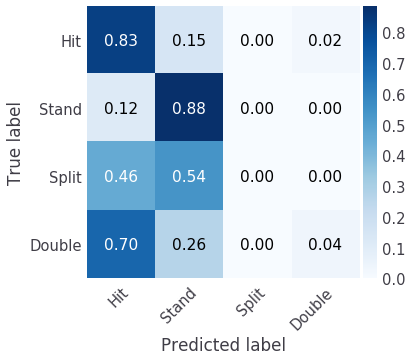

Accuracy: 65.53%

\begin{tabular}{lr}
\toprule
{} &   Correct \\
Label Name &           \\
\midrule
Double     &  0.036842 \\
Hit        &  0.828261 \\
Split      &  0.000000 \\
Stand      &  0.884488 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &   Correct \\
Prediction Name &           \\
\midrule
Double          &  0.388889 \\
Hit             &  0.667250 \\
Stand           &  0.650485 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &   Correct \\
HandSum &           \\
\midrule
4       &  0.400000 \\
5       &  1.000000 \\
6       &  0.800000 \\
7       &  1.000000 \\
8       &  0.860000 \\
9       &  0.500000 \\
10      &  0.271429 \\
11      &  0.100000 \\
12      &  0.580000 \\
13      &  0.820000 \\
14      &  0.822222 \\
15      &  0.775000 \\
16      &  0.542857 \\
17      &  0.600000 \\
18      &  0.560000 \\
19      &  1.000000 \\
20      &  1.000000 \\
21      &  1.000000 \\
22      &  0.000000 \\
\bottomrule
\end{tabular}



In [23]:
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='')

A_ = np.concatenate([A, np.ones((A.shape[0],1))],1)
Ai = np.linalg.pinv(A_)
x = Ai@b
out = A_@x
pred = np.argmax(out,1)
lab = np.argmax(b,1)

lab_to_class = list(action_to_class.keys())
l2c = lambda x: lab_to_class[x]

df = pd.DataFrame({'Prediction':pred, 'Label':lab,'HandSum':A[:,0:-1].sum(1), 'Hand':[a[0:-1] for a in A], 'Up Card':[a[-1] for a in A]})
df['Label Name'] = df.Label.apply(l2c)
df['Prediction Name'] = df.Prediction.apply(l2c)
df['Correct'] = df.Prediction == df.Label

# Plot normalized confusion matrix
classes = list(action_to_class.keys())
plot_confusion_matrix(lab, pred, classes=classes, normalize=True, title=' ', figsize=(6,6))
plt.show()
print('Accuracy: {:.2f}%\n'.format(df.Correct.mean()*100))
print(df.groupby('Label Name').Correct.mean().to_latex())
print(df.groupby('Prediction Name').Correct.mean().to_latex())
print(df.groupby('HandSum').Correct.mean().to_latex())

# KL Divergence with a Deep Model and SGD


In [37]:
from blackjacksim.entities import Deck, Hand
from blackjacksim.strategies import basic
import itertools
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tnrange


# Build A (Hand and Dealer's Up Card) and b (basic strategy Action)
action_to_class = {'Hit':[1,0,0,0],'Stand':[0,1,0,0],'Split':[0,0,1,0],'Double':[0.0,0,0,1]}

hands = [Hand(h) for h in itertools.product(Deck(),Deck())]
dups = Deck()

t = []
for hand, dup  in itertools.product(hands, dups):
    tup = tuple(c.value for c in (*hand,dup))
    c = (tup, basic(hand,dup))
    if c not in t:
        t.append(c)
print(len(t))
A = []
b = []
for  a, _b in t:
    A.append(a)
    b.append(action_to_class[_b])
    
A = np.stack(A)
b = np.array(b)

A = torch.from_numpy(A).float()
b = torch.from_numpy(b).float()

# Build Deep Model
class DeepBasicStrategy(nn.Module):
    def __init__(self):
        super(DeepBasicStrategy, self).__init__()
        block = lambda i, o: nn.Sequential(
            nn.Linear(i,o),
            nn.BatchNorm1d(o),
            nn.ReLU(),
            nn.Dropout(),
        )

        _model = []
        for i,o in [(3,2000), (2000,2000), (2000,1000), (1000,500), (500,250)]:
            _model.append(block(i,o))
        _model.append(nn.Linear(250,4))
        self.neural_net = nn.Sequential(*_model)
    def forward(self, x):
        return self.neural_net(x)

A = A.cuda()
b = b.cuda()

# Train Deep Model
criterion = nn.BCEWithLogitsLoss()
train_log = []
for _ in tnrange(1, position=0):
    for opt_name in ['SGD', 'SGD w/ momentum', 'SGD w/ Nesterov momentum', 'Adam']:
        model = DeepBasicStrategy()
        model = model.cuda()
        closure = None
        if opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
        elif opt_name == 'SGD w/ momentum':
            optimizer = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)
        elif opt_name == 'SGD w/ Nesterov momentum':
            optimizer = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9, nesterov=True)
        elif opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters())
        elif opt_name == 'LBFGS':
            optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)#, history_size=100, max_iter=3, max_eval=4)
            closure = lambda: criterion(model(A),b)
        tbar = tnrange(1000, position=1)
        for step in tbar:
            optimizer.zero_grad()
            model.train()
            out = model(A)
            loss = criterion(out, b)
            model.eval()
            out = model(A)
            pred = out.argmax(1)
            label = b.argmax(1)
            acc = (pred==label).float().mean().item()
            tbar.set_description("BCE Loss: {:.3f} Acc: {:.3f}".format(loss.item(), acc))
            loss.backward()
            optimizer.step(closure)
            train_log.append(
                {
                    'Optimizer':opt_name,
                    'Step':step,
                    'Accuracy':acc,
                    'Loss':loss.item(),
                }
            )



1001


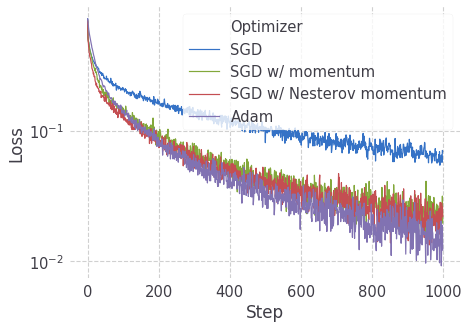

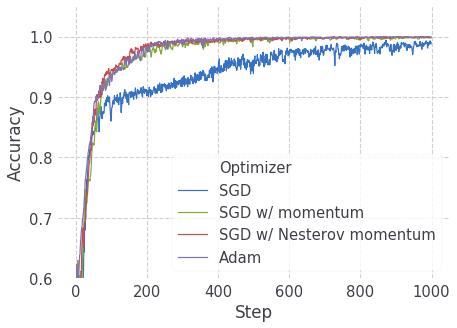

In [38]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

train_df = pd.DataFrame(train_log)
train_df['Error'] = 1-train_df.Accuracy
# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')

fig,ax = plt.subplots(1, figsize=(7, 5))
ax.set(yscale='log')
sns.lineplot(x='Step', y='Loss', hue='Optimizer', data=train_df, ax=ax)
plt.show()
fig,ax = plt.subplots(1, figsize=(7, 5))
ax.set(ylim=[.6,1.05])
sns.lineplot(x='Step', y='Accuracy', hue='Optimizer', data=train_df, ax=ax)
plt.show()